In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

#### Leemos dataset limpio

In [ ]:
df = pd.read_csv('../segunda entrega regresion/Dataset_definitivo.csv')

#### Visualizamos distribuciones numericas

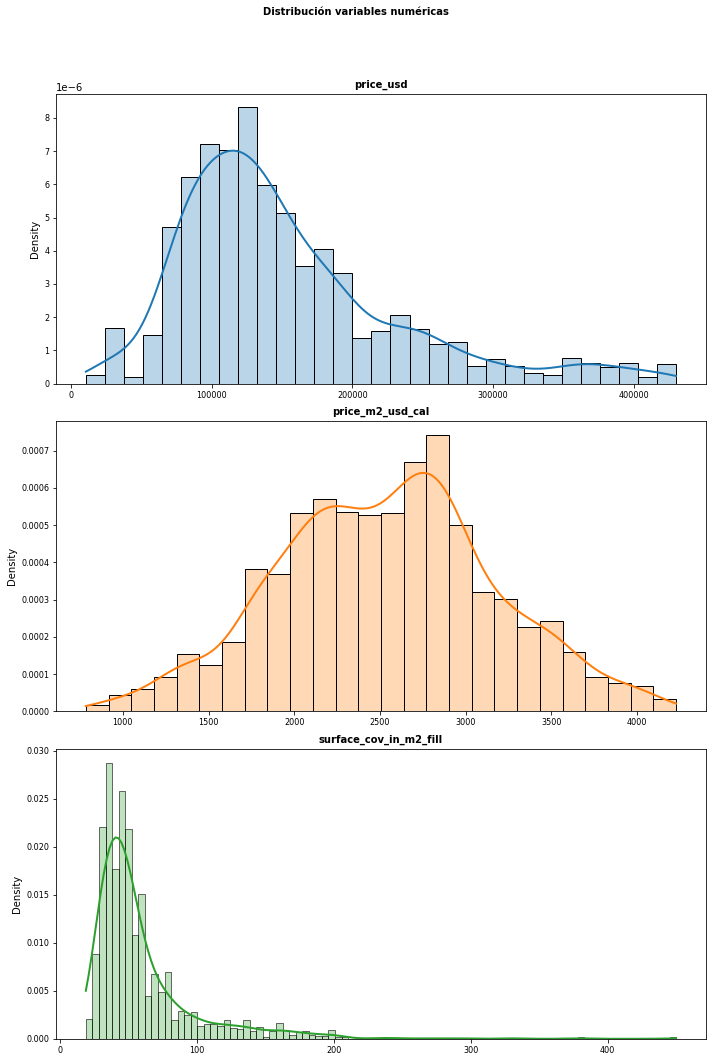

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "density",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

La unica que utilizaremos para features sera surface_cov_in_m2_fill dado que las otras son variables target(en realidad solo m2 pero price_usd esta muy correlacionada y por ende no podremos utilizarla).

Graficamos heatmap con la matriz de correlacion del dataframe

<AxesSubplot:>

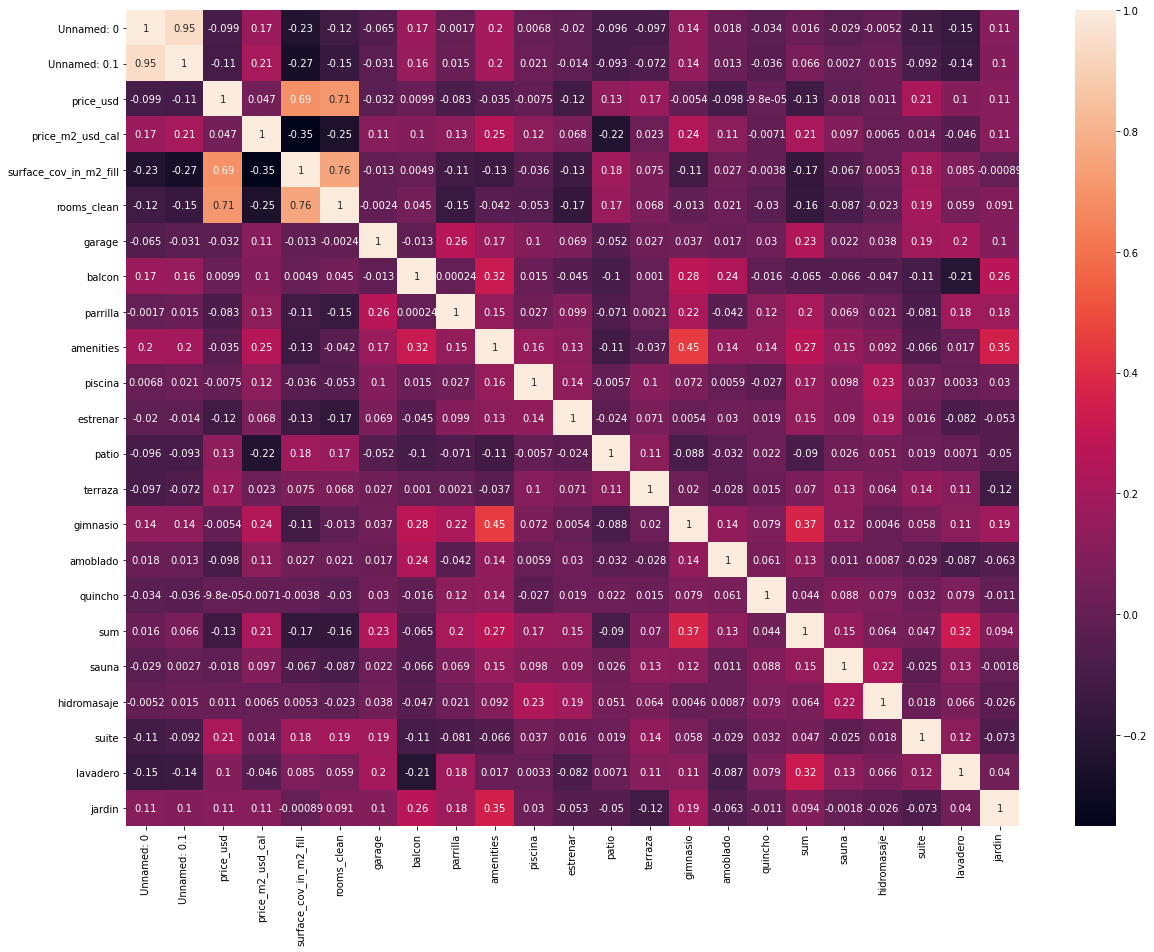

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot=True)

#### Preprocesamiento

Ahora vamos a estandarizar la columna price_m2_usd_cal dado que entendemos que algunos valores fueron extraidos de otras columnas pero queremos que tengan la maxima correlacion posible con surface.

In [ ]:
df['price_m2_usd_cal_def'] = df['price_usd'] / df['surface_cov_in_m2_fill']

In [ ]:
df[['price_m2_usd_cal_def','price_m2_usd_cal']]

,price_m2_usd_cal_def,price_m2_usd_cal
0,1935.483871,1702.13
1,2285.396667,2285.40
2,2314.646296,2314.65
3,2344.332593,2344.33
4,2374.018519,2374.02
...,...,...
1898,2258.064516,1764.71
1899,2285.714286,2051.28
1900,3142.857143,3142.86
1901,3657.142857,3368.42


Aca podemos ver como algunos valores difieren entre la nueva columna y la heredada del dataset.

Visualizamos nuevamente la matriz de correlacion y vemos que las relaciones de rooms y de surface son mas fuertes con la nueva variable generada. Utilizaremos la nueva.

<AxesSubplot:>

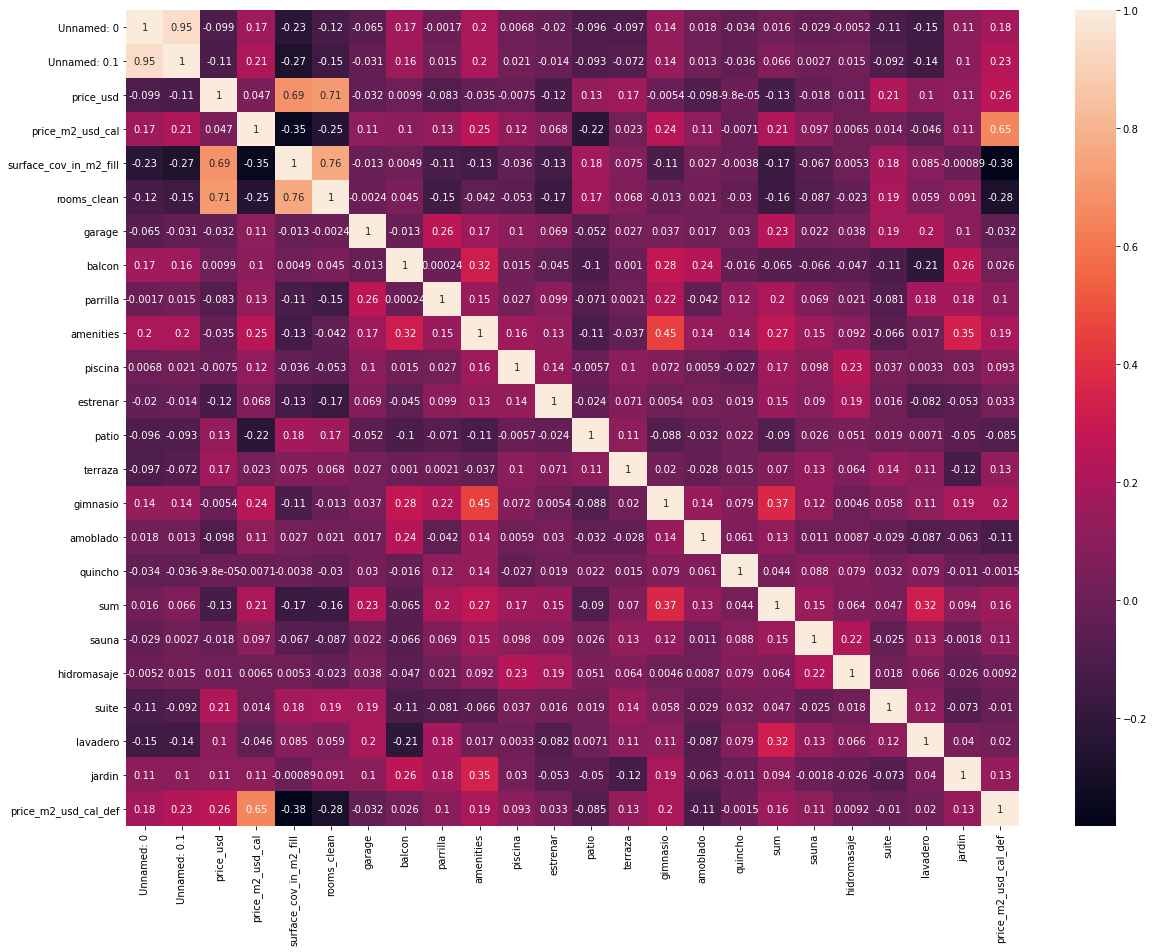

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot=True)

Ahora generaremos una columna polinomial con la unica variable numerica que tenemos disponible para su utilizacion: surface_cov_in_m2_fill.

In [ ]:
df['surface_cov_in_m2_fill2'] = df['surface_cov_in_m2_fill'] ** 2

Ahora generaremos las columnas dummies

In [ ]:
df_dummies = pd.get_dummies(df)

Ahora definiremos las features y la variable target.

In [ ]:
X = df_dummies.drop(['price_m2_usd_cal','Unnamed: 0', 'price_usd','price_m2_usd_cal_def'],axis=1)
y = df['price_m2_usd_cal_def']

Estamos dropeando en X todas las columnas que involucran precio y definiendo en y la columna nueva que habiamos creado. Esta sera nuestra variable target.

#### Vistazo rapido con stast models

In [ ]:
X_sm = sm.add_constant(X)

In [ ]:
modelo = sm.OLS(y,X_sm).fit()

In [ ]:
print(modelo.summary())

                             OLS Regression Results                             
Dep. Variable:     price_m2_usd_cal_def   R-squared:                       0.389
Model:                              OLS   Adj. R-squared:                  0.369
Method:                   Least Squares   F-statistic:                     19.57
Date:                  Sun, 16 Oct 2022   Prob (F-statistic):          1.34e-154
Time:                          18:37:46   Log-Likelihood:                -15052.
No. Observations:                  1903   AIC:                         3.023e+04
Df Residuals:                      1842   BIC:                         3.057e+04
Df Model:                            60                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

Se aprecian varias variables con P_value alto y muy alto.

#### Probamos modelos con sklearn y stats models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Generamos funcion para obtener resultados rapidos.

In [ ]:
def modelar(X):
    y = df['price_m2_usd_cal_def']
    Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=5)
    modelo_sk = LinearRegression()
    modelo_sk.fit(Xtrain,ytrain)
    ypred = modelo_sk.predict(Xtest)
    X_sm = sm.add_constant(X)
    modelo_stats = sm.OLS(y,X_sm).fit()
    print(modelo_stats.summary())
    return r2_score(ytest,ypred)
    

In [ ]:
modelar(X_sm)

                             OLS Regression Results                             
Dep. Variable:     price_m2_usd_cal_def   R-squared:                       0.389
Model:                              OLS   Adj. R-squared:                  0.369
Method:                   Least Squares   F-statistic:                     19.57
Date:                  Sun, 16 Oct 2022   Prob (F-statistic):          1.34e-154
Time:                          18:37:47   Log-Likelihood:                -15052.
No. Observations:                  1903   AIC:                         3.023e+04
Df Residuals:                      1842   BIC:                         3.057e+04
Df Model:                            60                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

0.35159005478514427

Iremos retirando las variables con p_values altos, solo dejando los que tengan un nivel de significancia menor a 0.025

In [ ]:
X_prueba1 = X_sm.drop(['piscina','amoblado', 'quincho','lavadero','jardin','Barrios_ Ayacucho', 'Barrios_ Caseros','Barrios_ General Paz','Barrios_ Independencia','Barrios_ José Hernández','Barrios_ Juan B. Justo', 'Barrios_ Kennedy', 'Barrios_ La Salle','Barrios_ La Toma','Barrios_ Parque Capital', 'Barrios_ Parque Chacabuco','Barrios_ Patricios', 'Barrios_ Primera Junta', 'Barrios_ Rivadavia','Barrios_ SEP', 'Barrios_ San José', 'Barrios_ San Lorenzo','Barrios_ San Nicolás','Barrios_ Sarmiento','Zonas _Zona Este','Zonas _Zona Noroeste','Zonas _Zona Norte', 'Zonas _Zona Sudeste'],axis=1)

In [ ]:
modelar(X_prueba1)

                             OLS Regression Results                             
Dep. Variable:     price_m2_usd_cal_def   R-squared:                       0.386
Model:                              OLS   Adj. R-squared:                  0.372
Method:                   Least Squares   F-statistic:                     27.83
Date:                  Sun, 16 Oct 2022   Prob (F-statistic):          7.72e-165
Time:                          18:37:47   Log-Likelihood:                -15058.
No. Observations:                  1903   AIC:                         3.020e+04
Df Residuals:                      1860   BIC:                         3.044e+04
Df Model:                            42                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

0.35973488394195285

In [ ]:
X_prueba2 = X_prueba1.drop(['parrilla','patio','hidromasaje','suite','Barrios_ Alberto','Barrios_ California','Barrios_ Centro' ,'Barrios_ Colón','Barrios_ Congreso','Zonas _Zona Nordeste','Zonas _Zona Sudoeste'],axis=1)

In [ ]:
modelar(X_prueba2)

                             OLS Regression Results                             
Dep. Variable:     price_m2_usd_cal_def   R-squared:                       0.381
Model:                              OLS   Adj. R-squared:                  0.370
Method:                   Least Squares   F-statistic:                     35.91
Date:                  Sun, 16 Oct 2022   Prob (F-statistic):          5.03e-169
Time:                          18:37:47   Log-Likelihood:                -15066.
No. Observations:                  1903   AIC:                         3.020e+04
Df Residuals:                      1870   BIC:                         3.038e+04
Df Model:                            32                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

0.35682242367824224

In [ ]:
X_prueba3 = X_prueba2.drop(['surface_cov_in_m2_fill2','Barrios_ Carrara','Barrios_ Güemes','Barrios_ Marcos Sastre','Barrios_ Santa Rita','Zonas _Zona Oeste'],axis=1)

In [ ]:
modelar(X_prueba3)

                             OLS Regression Results                             
Dep. Variable:     price_m2_usd_cal_def   R-squared:                       0.376
Model:                              OLS   Adj. R-squared:                  0.367
Method:                   Least Squares   F-statistic:                     43.44
Date:                  Sun, 16 Oct 2022   Prob (F-statistic):          9.12e-171
Time:                          18:37:47   Log-Likelihood:                -15073.
No. Observations:                  1903   AIC:                         3.020e+04
Df Residuals:                      1876   BIC:                         3.035e+04
Df Model:                            26                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

0.3555318742017688

In [ ]:
X_prueba4 = X_prueba3.drop(['rooms_clean'],axis=1)

In [ ]:
modelar(X_prueba4)

                             OLS Regression Results                             
Dep. Variable:     price_m2_usd_cal_def   R-squared:                       0.375
Model:                              OLS   Adj. R-squared:                  0.367
Method:                   Least Squares   F-statistic:                     45.10
Date:                  Sun, 16 Oct 2022   Prob (F-statistic):          2.90e-171
Time:                          18:37:47   Log-Likelihood:                -15074.
No. Observations:                  1903   AIC:                         3.020e+04
Df Residuals:                      1877   BIC:                         3.034e+04
Df Model:                            25                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

0.35473507839137

In [ ]:
X_prueba5 = X_prueba4.drop(['Barrios_ Comercial'],axis=1)

In [ ]:
modelar(X_prueba5)

                             OLS Regression Results                             
Dep. Variable:     price_m2_usd_cal_def   R-squared:                       0.373
Model:                              OLS   Adj. R-squared:                  0.365
Method:                   Least Squares   F-statistic:                     46.63
Date:                  Sun, 16 Oct 2022   Prob (F-statistic):          6.57e-171
Time:                          18:37:47   Log-Likelihood:                -15077.
No. Observations:                  1903   AIC:                         3.020e+04
Df Residuals:                      1878   BIC:                         3.034e+04
Df Model:                            24                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

0.3517381529215249

In [ ]:
X_prueba6 = X_prueba5.drop(['garage','balcon','sauna','Barrios_ Acosta'],axis=1)

In [ ]:
modelar(X_prueba6)

                             OLS Regression Results                             
Dep. Variable:     price_m2_usd_cal_def   R-squared:                       0.367
Model:                              OLS   Adj. R-squared:                  0.361
Method:                   Least Squares   F-statistic:                     54.62
Date:                  Sun, 16 Oct 2022   Prob (F-statistic):          1.87e-170
Time:                          18:38:08   Log-Likelihood:                -15086.
No. Observations:                  1903   AIC:                         3.021e+04
Df Residuals:                      1882   BIC:                         3.033e+04
Df Model:                            20                                         
Covariance Type:              nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

0.3562328735335779

Encontramos la mejor combinacion de variables features para el modelo habiendo sacrificado escaso r2.

In [ ]:
X_prueba6.columns

Index(['const', 'Unnamed: 0.1', 'surface_cov_in_m2_fill', 'amenities',
       'estrenar', 'terraza', 'gimnasio', 'sum', 'Barrios_ ATE',
       'Barrios_ Alto Palermo', 'Barrios_ Avenida', 'Barrios_ Boedo',
       'Barrios_ Jardín', 'Barrios_ Mirador', 'Barrios_ Rosedal',
       'Barrios_ San Martín', 'Barrios_ Urquiza',
       'Barrios_Remedios de Escalada', 'Zonas _Zona Central',
       'Zonas _Zona Cerro', 'Zonas _Zona Guiñazu', 'Zonas _Zona Sur'],
      dtype='object')

Grafiquemos en un heatmap estas variables junto con nuestro target.

<AxesSubplot:>

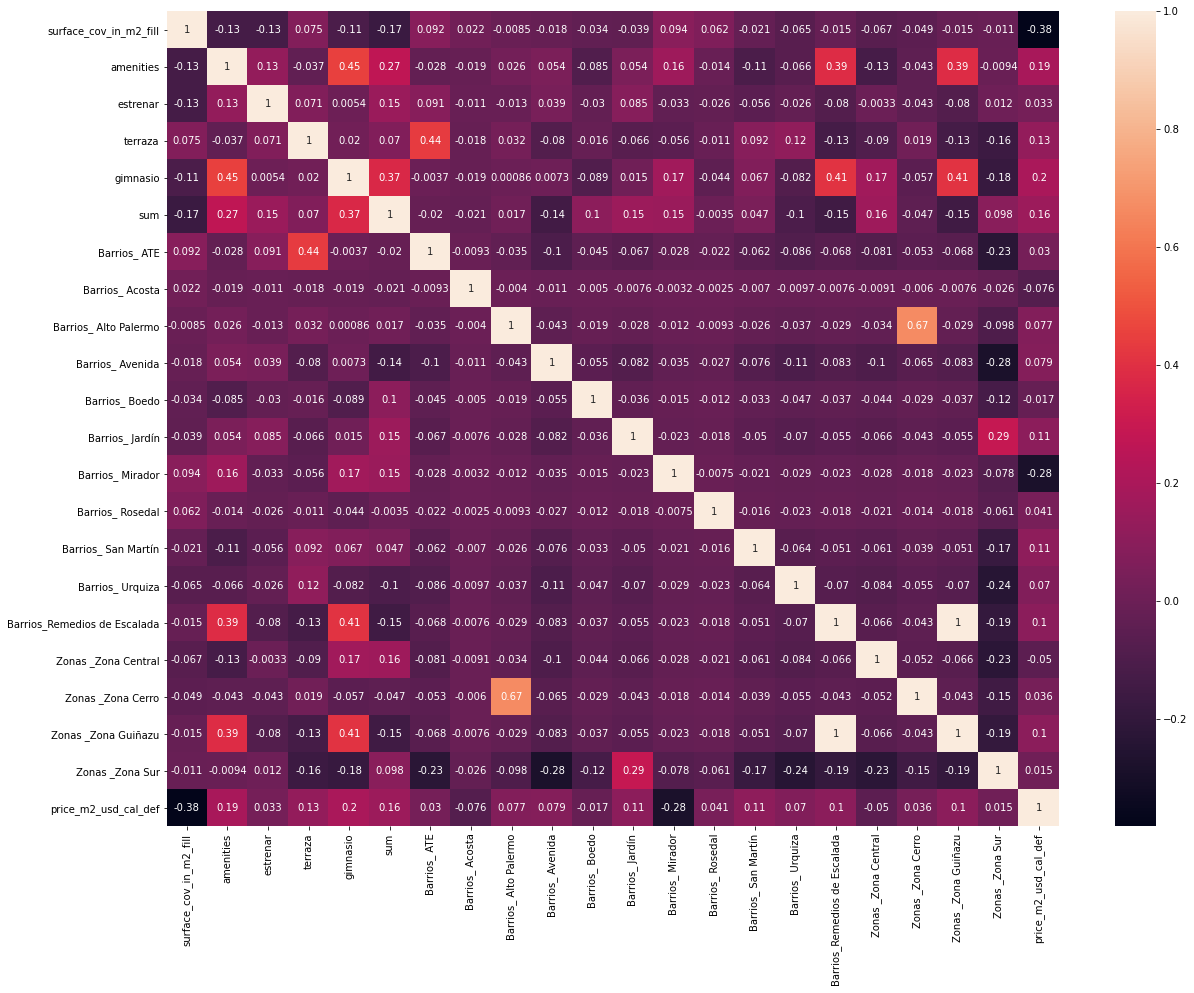

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap((df_dummies.loc[:,['surface_cov_in_m2_fill', 'amenities', 'estrenar', 'terraza',
       'gimnasio', 'sum', 'Barrios_ ATE', 'Barrios_ Acosta',
       'Barrios_ Alto Palermo', 'Barrios_ Avenida', 'Barrios_ Boedo',
       'Barrios_ Jardín', 'Barrios_ Mirador', 'Barrios_ Rosedal',
       'Barrios_ San Martín', 'Barrios_ Urquiza',
       'Barrios_Remedios de Escalada', 'Zonas _Zona Central',
       'Zonas _Zona Cerro', 'Zonas _Zona Guiñazu', 'Zonas _Zona Sur','price_m2_usd_cal_def']]).corr(),annot=True)

#### Ajuste final con sklear

In [ ]:
X = X_prueba6.drop(['const'],axis=1)
y = df_dummies['price_m2_usd_cal_def']

In [ ]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=5)

In [ ]:
modelo = LinearRegression()

In [ ]:
modelo.fit(Xtrain,ytrain)

LinearRegression()

In [ ]:
ypred = modelo.predict(Xtest)

In [ ]:
ypred_train = modelo.predict(Xtrain)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(ytest, ypred)

479426.30154711095

In [ ]:
# Veamos los coeficienetes obtenidos,
print('Coeficientes: \n', modelo.coef_)
print('------------------------------------------------------------------------------')
# Este es el valor donde corta el eje Y (en X=0)
print('Intercepto: \n', modelo.intercept_)
print('------------------------------------------------------------------------------')
# Error Cuadrado Medio
print(f"Mean squared error: {mean_squared_error(ytest, ypred)}")
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('------------------------------------------------------------------------------')
print(f'R2 score train: {r2_score(ytrain, ypred_train)}')
print('------------------------------------------------------------------------------')
print(f'R2 score test: {r2_score(ytest, ypred)}')

Coeficientes: 
 [ 3.61296470e-03 -5.53802880e+00  2.35443902e+02 -1.70422287e+02
  2.85459776e+02  1.56729040e+02  1.94003505e+02  4.62662555e+02
  3.91152036e+02  6.55000735e+02  3.00300606e+02  2.82748160e+02
 -2.12264130e+03  1.06028495e+03  9.11137455e+02  5.03958877e+02
  2.59133876e+02  3.10436546e+02  3.32407653e+02  2.59133876e+02
  4.25077694e+02]
------------------------------------------------------------------------------
Intercepto: 
 2162.207322727696
------------------------------------------------------------------------------
Mean squared error: 479426.30154711095
------------------------------------------------------------------------------
R2 score train: 0.3662878813167164
------------------------------------------------------------------------------
R2 score test: 0.35623287353358923


#### Regularizacion

In [ ]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

0.001
2179.665303296608
R2:0.355, MSE:480055.01, RMSE:692.86


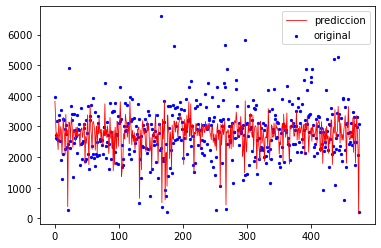

In [ ]:
alphas = np.linspace(0.001, 100, 1000)
elastic_cv=ElasticNetCV(alphas=alphas, cv=5)
model = elastic_cv.fit(Xtrain, ytrain)
print(model.alpha_)
print(model.intercept_)
ypred = model.predict(Xtest)
score = model.score(Xtest, ytest)
mse = mean_squared_error(ytest, ypred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
      .format(score, mse, np.sqrt(mse)))
x_ax = range(len(Xtest))
plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="prediccion")
plt.legend()
plt.show()